Trying to reproduce Figure 7.2 by implementing n-step TD algorithm, which is a bridge between MC learning and TD(0) learning. When n=1, then it becomes TD(0), when n -> infinite, then it's MC. An intermediate value of n could potentiall be better than either extreme.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 7)

from sklearn.metrics import mean_squared_error

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# 19-state takes quite a while to compute, so use 9 instead
NUM_STATES = 9
STATES = np.arange(1, NUM_STATES + 1)

# Add 2 exit state, the state after exit actoin, whose state value will be 0
EXIT_STATES = [0, NUM_STATES + 1]
EXIT_REWARDS = [-1, 1]

# Here is a more systematic way of calculating true value function
prob_exit_right = STATES / (NUM_STATES + 1)
V_TRUE = (1 - prob_exit_right) * EXIT_REWARDS[0] + prob_exit_right * EXIT_REWARDS[1]

NUM_ALL_STATES = NUM_STATES + len(EXIT_STATES)

STARTING_STATE = (NUM_STATES + 1) / 2 + 1 # set starting state to the middle; +1 offset the first exit state

print(STATES)
print(V_TRUE)
print('starting at State: {0}'.format(int(STARTING_STATE)))

[1 2 3 4 5 6 7 8 9]
[-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
starting at State: 6


In [3]:
def is_exit_state(state):
    return state in EXIT_STATES

In [4]:
def take_action(s0):
    rand = np.random.random()
    if rand >= 0.5:
        s1 = s0 - 1
    else:
        s1 = s0 + 1
        
    if s1 == EXIT_STATES[1]:
        reward = EXIT_REWARDS[1]
    elif s1 == EXIT_STATES[0]:
        reward = EXIT_REWARDS[0]
    else:
        reward = 0
    return s1, reward

calc_target implements Eq. (7.1) in the Sutton and Barto textbook
$G_{t}^{(n)} = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... + \gamma^{n-1} R_{t+n} + \gamma ^{n} V(S_{t+n})$

In [5]:
def calc_target(v_func, s0, gamma, n_step):
    """
    Calculate the target of the backup, represented by G in the textbook

    When n_step is 1, it becomes TD(0)

    This implementation is on-line
    """
    assert n_step >= 1
    assert 0 < gamma <= 1
    
    target = 0
    for i in range(n_step):
        s1, reward_i = take_action(s0)
        target += (gamma ** i * reward_i)
        s0 = s1

        if i == 0:
            # track the immediate next state for return
            s_prime = s1

        if is_exit_state(s1):
            break
    target += gamma ** n_step * v_func[s1]
    return s_prime, target

$\Delta V_{t}(S_{t}) = \alpha [G_{t}^{(n)} - V_{t}(S_{t})]$

In [6]:
def run_a_episode(v_func, s0=STARTING_STATE, alpha=0.1, gamma=1, n_step=1):
    while True:
#         s1, reward = take_action(s0)
        s1, target = calc_target(v_func, s0, gamma, n_step)
        v_func[s0] = v_func[s0] + alpha * (target - v_func[s0])
        s0 = s1
        if s1 in EXIT_STATES:
            break
    return v_func

In [7]:
def init_v_func(num_all_states):
    """initialize value function"""
    v_func = np.repeat(0.5, NUM_ALL_STATES)
    # The value of EXIT_STATES should be 0
    v_func[0], v_func[-1] = 0, 0
    return v_func

In [8]:
# mse of the inital value function and true value function
print(mean_squared_error(init_v_func(NUM_ALL_STATES)[1:-1], V_TRUE))

0.516666666667


In [9]:
alpha_list = [0.01, 0.02, 0.04, 0.08, 0.1, 0.16, 0.32, 0.4, 0.5, 0.64, 0.8, 1]
print('alpha_list: {0}'.format(alpha_list))
# n_step_list = [1000, 200, 100, 60, 30, 15, 8, 5, 2, 1]
n_step_list = [1000, 200, 100, 30, 8, 2, 1]
n_episodes = 10
n_experiments = 100

mse = np.zeros((n_experiments, len(alpha_list), len(n_step_list)))

alpha_list: [0.01, 0.02, 0.04, 0.08, 0.1, 0.16, 0.32, 0.4, 0.5, 0.64, 0.8, 1]


This cell takes the most time to run

In [10]:
for expi in range(n_experiments):
    if (expi + 1) % 20 == 0:
        print('working on Experiment {0}'.format(expi + 1))
    for i, alpha in enumerate(alpha_list):
#         print('working on alpha = {0}'.format(alpha))
        for j, n_step in enumerate(n_step_list):
    #         print('working on alpha = {0}, n_step = {1}'.format(alpha, n_step))
            v_func = init_v_func(NUM_ALL_STATES)
            for _ in range(n_episodes):
                v_func = run_a_episode(v_func, alpha=alpha, n_step=n_step)
            mse[expi, i, j] = mean_squared_error(V_TRUE, v_func[1:-1])

/Users/zyxue/miniconda3/envs/kaggle/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/zyxue/miniconda3/envs/kaggle/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


working on Experiment 20
working on Experiment 40
working on Experiment 60
working on Experiment 80
working on Experiment 100


In [11]:
rms = np.sqrt(mse)

In [12]:
rms.shape

(100, 12, 7)

In [13]:
rms_ave = rms.mean(axis=0)
rms_std = rms.std(axis=0)

#### without limited y axis

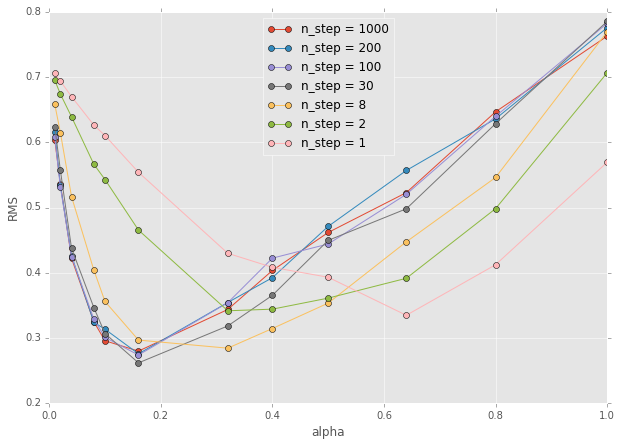

In [16]:
for i, n_step in enumerate(n_step_list):
    vals = rms_ave[:, i]
    std = rms_std[:, i]
    plt.plot(alpha_list, vals, 'o-', label='n_step = {0}'.format(n_step))

plt.legend(loc='best')
plt.xlabel('alpha')
plt.ylabel('RMS')

Wow, the results changes so much just by tuning reward values. Seems that the best $\alpha$ and $n\_step$ is very problem-dependent.

#### view separately for clarity

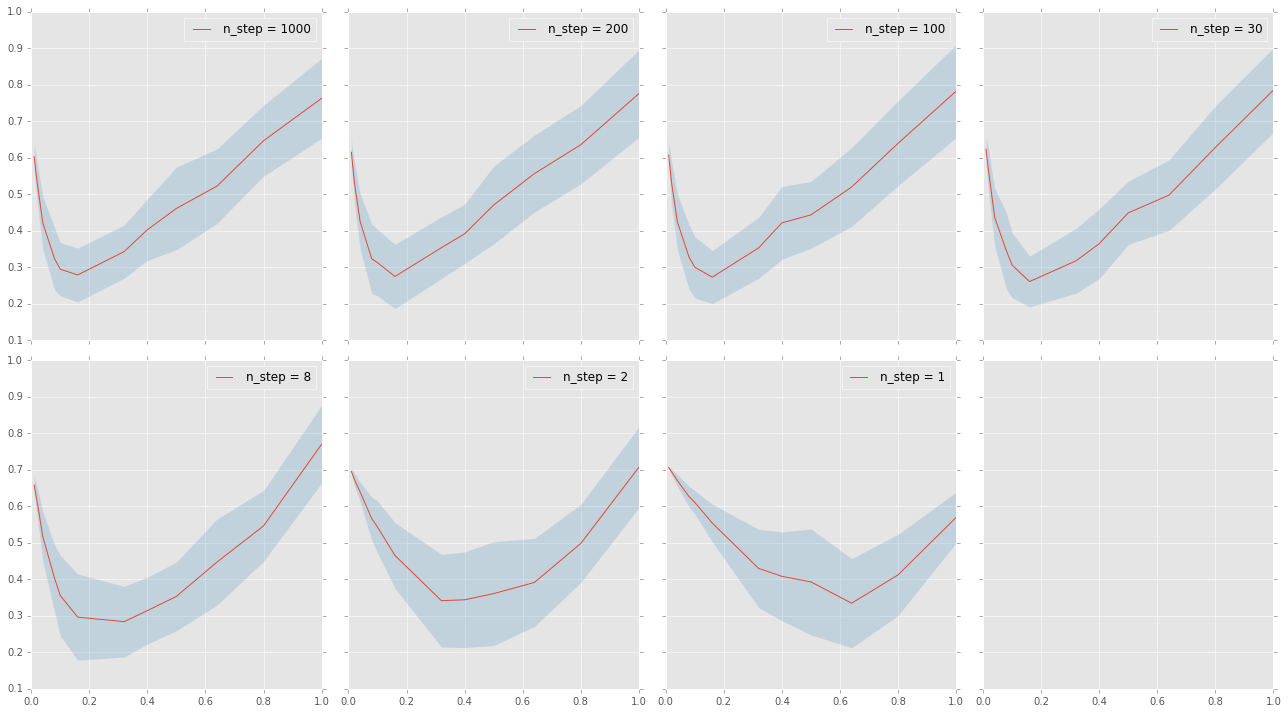

In [17]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(18, 10))
axes = axes.ravel()

for i, n_step in enumerate(n_step_list):
    ax = axes[i]
    vals = rms_ave[:, i]
    std = rms_std[:, i]
    ax.plot(alpha_list, vals, label='n_step = {0}'.format(n_step))
    ax.fill_between(alpha_list, vals - std, vals + std, alpha=0.2)
    ax.legend()

plt.tight_layout()

**Note**: When $\alpha$ increases, the error increases in general, but doesn't seem to hold strictly esp. when n_step = 1 or 2

The following part is similar to random walk with TD(0), but you can play around by adjusting n_step

## See how it converges to true value function as the number of episodes increases

working on 0
working on 1
working on 10
working on 100
working on 500
working on 1000


/Users/zyxue/miniconda3/envs/kaggle/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/zyxue/miniconda3/envs/kaggle/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


working on 2000


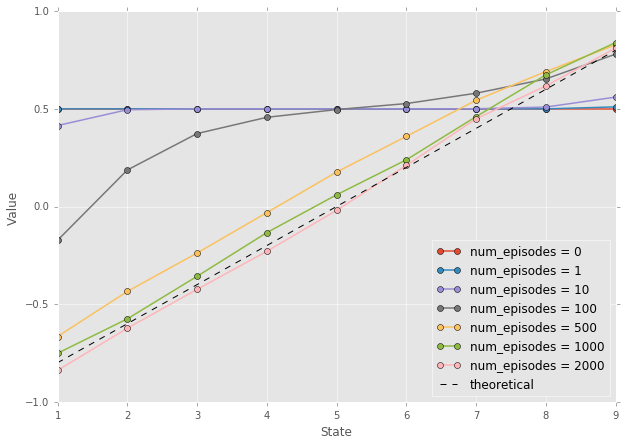

In [19]:
for num_episodes in [0, 1, 10, 100, 500, 1000, 2000]:
    print('working on {0}'.format(num_episodes))
    v_func = init_v_func(NUM_ALL_STATES)
    for i in range(num_episodes):
        v_func = run_a_episode(v_func, alpha=0.02, n_step=1)

    # v_func[1:-1] no need to plot value of EXIT_STATES
    plt.plot(range(1, NUM_STATES + 1), v_func[1:-1], 'o-', lw=1.5,
             label='num_episodes = {0}'.format(num_episodes))

# plot theorectical line
plt.plot(range(1, NUM_STATES + 1), V_TRUE, '--', color='black',
         label='theoretical')
plt.legend(loc='best')
plt.xlabel('State')
plt.ylabel('Value')
# plt.xlim(0, NUM_STATES)
# plt.ylim(0, 1)

## See how mse changes along number of episodes

working on 0.01


/Users/zyxue/miniconda3/envs/kaggle/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/zyxue/miniconda3/envs/kaggle/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


working on 0.05
working on 0.1
working on 0.2
working on 0.5


(-0.01, 0.60000000000000009)

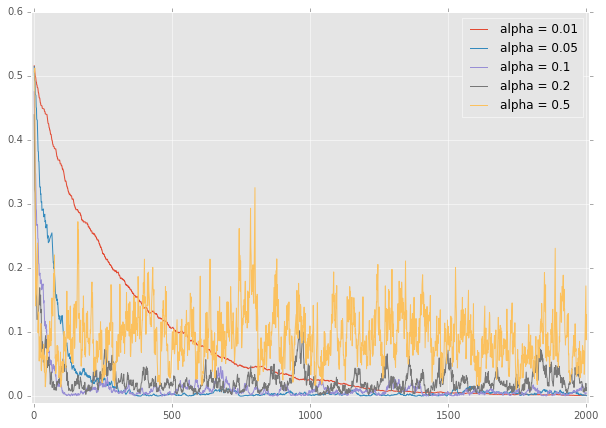

In [21]:
num_episodes = 2000
for alpha in [0.01, 0.05, 0.1, 0.2, 0.5]:
    print('working on {0}'.format(alpha))
    # The value of EXIT_STATES should be 0
    v_func = init_v_func(NUM_ALL_STATES)
    mse = []
    for i in range(num_episodes):
        v_func = run_a_episode(v_func, alpha=alpha, n_step=1)
        mse.append(mean_squared_error(V_TRUE, v_func[1:-1]))

    plt.plot(np.arange(num_episodes) + 1, mse, lw=1,
             label='alpha = {0}'.format(alpha))
    
plt.legend(loc='best')
plt.xlim(-10, num_episodes + 10)
plt.ylim(-0.01, plt.ylim()[1])

Larger alpha makes it hard to converge, $\alpha=0.5$ is NO good!